In [83]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np

from superfv.euler_solver import EulerSolver

In [ ]:
gamma = 1.4
rho0 = 1
cs0 = 1
P0 = 1 / gamma
A = 1e-5


def nonlinear_sound_wave(array_slicer, x, y, z, t):
    _slc = array_slicer

    def vp(x, t):
        return A * np.sin(2 * np.pi * (x - t)) - A**2 * (
            gamma + 1
        ) / 4 * 2 * np.pi * t * np.sin(4 * np.pi * (x - t))

    out = np.zeros((5, *x.shape))
    out[_slc("rho")] = rho0 + rho0 * vp(x, 0)  # only valid for t=0
    out[_slc("vx")] = vp(x, t)
    out[_slc("P")] = P0 + gamma * P0 * vp(x, 0)  # only valid for t=0
    return out


N = 1024
p = 3

solver = EulerSolver(
    ic=partial(nonlinear_sound_wave, t=0),
    gamma=gamma,
    nx=N,
    p=p,
    CFL=0.8,
    riemann_solver="llf",
    flux_recipe=3,
    lazy_primitives=False,
    # ZS=True,
    # adaptive_timestepping=False,
    # SED=True,
)
solver.run(n=10)

100%|██████████| 10/10 [00:00<00:00, 174.92it/s]


In [85]:
solver.t

0.00781240625160321

Text(0, 0.5, 'Error in velocity')

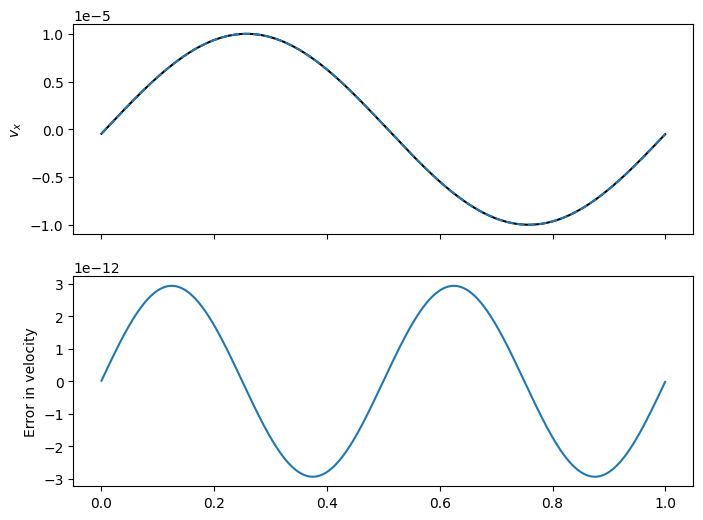

In [86]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 6))

_slc = solver.array_slicer
vx_numerical = solver.snapshots[-1]["wcc"][_slc("vx")].flatten()
vx_exact = nonlinear_sound_wave(_slc, solver.X, solver.Y, solver.Z, solver.t)[
    _slc("vx")
].flatten()

axs[0].set_ylabel(r"$v_x$")
axs[0].plot(solver.x, vx_exact, color="k", label="t=0")
solver.plot_1d_slice(axs[0], "vx", array="wcc", x=None, linestyle="--", label="t=1")

axs[1].plot(solver.x, vx_numerical - vx_exact)
axs[1].set_ylabel("Error in velocity")